# Display Accuracy and Loss

## Load Data

In [106]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys
import os
_path = '.'
sys.path.append(os.path.join(_path))



def parse_tf_events_file(events_path, tag, time_horizon=None):
    ea = EventAccumulator(events_path).Reload()
    print(ea)
    tag_values, steps = [], []
    for event in ea.Scalars(tag):
        if time_horizon is None or event.step <= time_horizon:
            tag_values.append(event.value)
            steps.append(event.step)
    return steps, tag_values

class ExperimentConfig:
    def __init__(self, base_path, experiment, seeds, algorithms, events, lr_list,
                 alphas, n_clients_list, availabilities, n_rounds, participations):
        """
        base_path: path to the folder logs/
        experiment: name of exp (str: mnist_CI_based_availability)
        seeds: list of seeds
        algorithms: list of algorithms
        events: list of events (e.g. ["global"])
        # b_values:
        lr_list: list of learning rates
        alphas: list of alpha values (for the iid - non iid -ness)
        n_clients_list: list of number of clients
        availabilities: list of availability types (e.g. ["local_mean", "global_mean", "random", "local_mean_green", "cyclic"])
        n_rounds: number of FL rounds
        participations: list with "unknown" and/or "known" (whether we work with the participation probabilities estimator or the true values)
        """
        self.base_path = base_path
        self.experiment = experiment
        self.seeds = seeds
        self.algorithms = algorithms
        self.events = events
        # self.b_values = b_values
        self.lr_list = lr_list
        self.alphas = alphas
        self.n_clients_list = n_clients_list
        self.availabilities = availabilities
        self.n_rounds = n_rounds
        self.participations = participations

    def get_event_dir(self, algo, lr, seed, event, alpha, n_clients, availability, n_rounds, participation):
        """
        algorithm: algorithm (str:fedavg, defvarp or fedstale)
        lr: learning rate (str)
        b: beta (str)
        seed:
        event:
        """
        path = f"{self.base_path}/{self.experiment}/clients_{n_clients}/{availability}"
        # path += f"/{algo}/b_{b}" if algo == "mixture" else f"/{algo}" # in case we vary beta
        path += f"/{algo}/{participation}_participation_probs"
        path += f"/alpha_{alpha}/lr_{lr}/seed_{seed}/rounds_{n_rounds}/train/{event}"

        path = os.path.join(self.base_path, self.experiment, "clients_"+n_clients, availability,
                     algo, participation+"_participation_probs", "alpha_"+alpha, "lr_"+lr, 
                     "seed_"+seed, "rounds_"+n_rounds, "train", event)

        return path

# Load and Process Experiment Results
def load_experiment_results(config):
    results = [] 
    for lr in tqdm(config.lr_list, desc="Processing experiments"):
        # time_horizon = time_horizons[p]  
        for algorithm in config.algorithms:
            # b_loop = config.b_values if algorithm == 'mixture' else [None] # in case we vary beta
            # for b in b_loop:
            for event in config.events:
                for seed in config.seeds:
                    for a in config.alphas:
                        for n_c in config.n_clients_list:
                            for av in config.availabilities:
                                for part in config.participations:

                                    event_dir = config.get_event_dir(algorithm, lr, seed, 
                                                                        event, a, n_c, av, 
                                                                        config.n_rounds, part)                                    
                                    # files = os.listdir(event_dir)

                                    if os.path.exists(event_dir):
                                        print('x')
                                        # _, values = parse_tf_events_file(event_dir, tag="Test/Metric", time_horizon=time_horizon)
                                        _, test_accuracy_values = parse_tf_events_file(event_dir, tag="Test/Metric")
                                        _, test_loss_values = parse_tf_events_file(event_dir, tag="Test/Loss")
                                        _, train_accuracy_values = parse_tf_events_file(event_dir, tag="Train/Metric")
                                        _, train_loss_values = parse_tf_events_file(event_dir, tag="Train/Loss")
                                        # tag can be: 'Train/Loss', 'Train/Metric', 'Test/Loss', 'Test/Metric'
                                        max_accuracy = np.array(test_accuracy_values).max() * 100
                                        results.append({
                                            "algorithm": algorithm, "availability": av,
                                            "alpha": a, "participation": part,
                                            "max_test_accuracy": float(max_accuracy),
                                            # "test_accuracy": list(test_accuracy_values),
                                            # "test_loss": test_loss_values,
                                            # "train_accuracy": train_accuracy_values,
                                            # "train_loss": train_loss_values,
                                            "test_accuracy": "Test/Metric",
                                            "test_loss": "Test/Loss",
                                            "train_accuracy": "Train/Metric",
                                            "train_loss": "Train/Loss",
                                            "seed": seed,
                                            "lr": lr, "event": event, "n_clients": n_c,
                                            # "event_dir": event_dir
                                        })

                                        # "b": float(b) if b else np.nan # in case we vary beta
    return pd.DataFrame(results)

# Main
# config = ExperimentConfig(base_path=os.path.join('.', 'logs'), experiment="mnist_CI_based_availability", seeds=["12"],
#                           algorithms=["fedavg", "fedvarp", "fedstale"], events=["global"],
#                           lr_list=["5e-3"], alphas=["100000", "0.1"], n_clients_list=["7"],
#                           availabilities=["local_mean", "global_mean", "random", "local_mean_green", "cyclic"],
#                           n_rounds="100", participations=["known", "unknown"]
#                          )
config = ExperimentConfig(base_path=os.path.join('.', 'logs'), experiment="mnist_CI_based_availability", seeds=["12"],
                          algorithms=["fedavg", "fedvarp", "fedstale"], events=["global"],
                          lr_list=["5e-3"], alphas=["-1"], n_clients_list=["7"],
                          availabilities=[
                            #   "CI-threshold-local-mean",
                              "CI-threshold-global-mean",
                              "CI-threshold-median",
                              "CI-threshold-penalized-local-mean",
                              "carbon-budget",
                              "carbon-budget-fine-tuning",
                            #   "random_for_CI-threshold-local-mean",
                              "random_for_CI-threshold-global-mean",
                              "random_for_CI-threshold-penalized-local-mean",
                              "random_for_CI-threshold-median",
                              "random_for_carbon-budget",
                              "random_for_carbon-budget-fine-tuning"
                          ],
                          n_rounds="100", participations=["known"]
                         )

results_df = load_experiment_results(config)

# ./logs/mnist_CI_based_availability/clients_7/local_mean/fedavg/known_participation_probs/alpha_100000/lr_5e3/seed_12/rounds_100/train/global
# \logs\mnist_CI_based_availability\clients_7\local_mean\fedavg\known_participation_probs\alpha_100000\lr_5e-3\seed_12\rounds_100\train\global

Processing experiments:   0%|          | 0/1 [00:00<?, ?it/s]

x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x


Processing experiments: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

x
x
x


In [107]:
results_df.columns
#  b_values=["0.2", "0.5", "0.8"]
# results_df

Index(['algorithm', 'availability', 'alpha', 'participation',
       'max_test_accuracy', 'test_accuracy', 'test_loss', 'train_accuracy',
       'train_loss', 'seed', 'lr', 'event', 'n_clients'],
      dtype='object')

## Plots

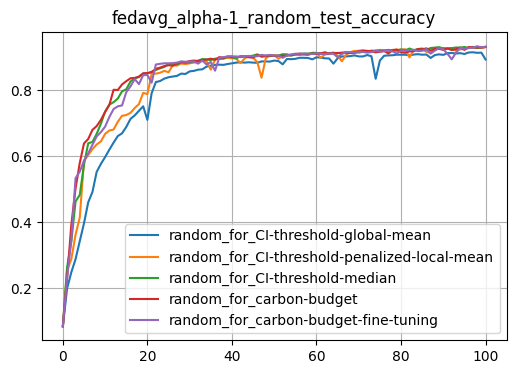

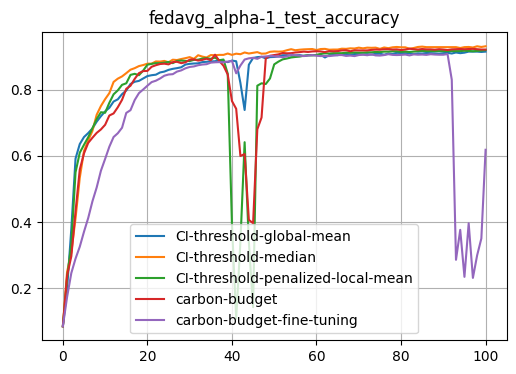

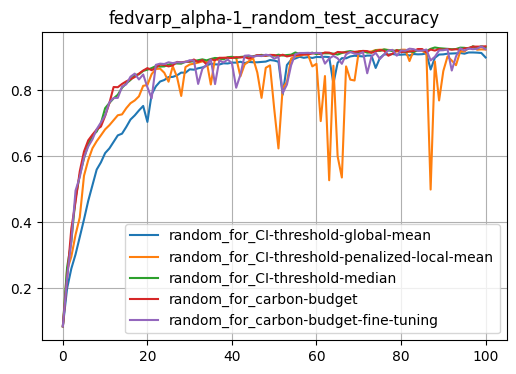

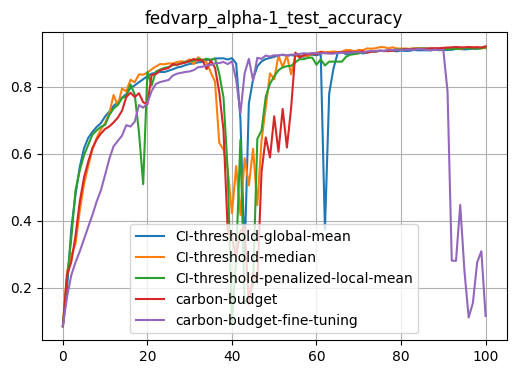

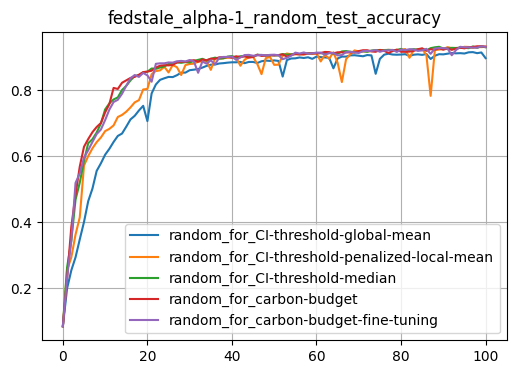

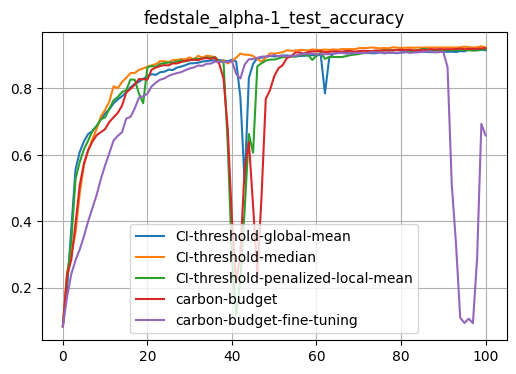

In [108]:
import matplotlib.pyplot as plt

def plot_availability_comparison(config, res, metric):

    
    xvalues = [i for i in range(int(config.n_rounds)+1)]

    for lr in config.lr_list:
        for algo in config.algorithms:
            for event in config.events:
                for seed in config.seeds:
                    for a in config.alphas:
                        for n_c in config.n_clients_list:
                            # for av in config.availabilities:
                            for part in config.participations:

                                    res_tmp = res[(res.lr == lr) & (res.algorithm == algo) & (res.event == event) &
                                                (res.seed == seed) & (res.alpha == a) & (res.n_clients == n_c) &
                                                (res.participation == part)]
                                    
                                    # display(res_plot) # this is what we are going to compare
                                    
                                    fig = plt.figure(figsize=(6, 4))
                                    for av in config.availabilities:
                                        if 'random' in av:
                                            res_plot = res_tmp[res_tmp.availability == av]
                                            event_dir = config.get_event_dir(algo, lr, seed, 
                                                                            event, a, n_c, av, 
                                                                            config.n_rounds, part)  
                                            # display(res_plot)
                                            # print('xxx')
                                            tag = res_plot[metric].values[0]
                                            _, test_accuracy_values = parse_tf_events_file(event_dir, tag=tag)
                                            # print(av)
                                            # yvalues = res_plot[(res_plot.availability == av)][metric]
                                            # print(res_plot[(res_plot.availability == av)][metric])
                                            plt.plot(xvalues, test_accuracy_values, label= av)
                                            title = ('_').join([algo, 'alpha'+a, 'random', metric])
                                            plt.title(title)
                                    plt.legend()
                                    plt.grid()
                                    plt.savefig('figures/accross_availabilities/'+title+'.png', bbox_inches='tight')
                                    plt.show()

                                    fig = plt.figure(figsize=(6, 4))
                                    for av in config.availabilities:
                                        if 'random' not in av:
                                            res_plot = res_tmp[res_tmp.availability == av]
                                            event_dir = config.get_event_dir(algo, lr, seed, 
                                                                            event, a, n_c, av, 
                                                                            config.n_rounds, part)  
                                            # display(res_plot)
                                            # print('xxx')
                                            tag = res_plot[metric].values[0]
                                            _, test_accuracy_values = parse_tf_events_file(event_dir, tag=tag)
                                            # print(av)
                                            # yvalues = res_plot[(res_plot.availability == av)][metric]
                                            # print(res_plot[(res_plot.availability == av)][metric])
                                            plt.plot(xvalues, test_accuracy_values, label= av)
                                            title = ('_').join([algo, 'alpha'+a, metric])
                                            plt.title(title)
                                    plt.legend()
                                    plt.grid()
                                    plt.savefig('figures/accross_availabilities/'+title+'.png', bbox_inches='tight')
                                    plt.show()
    
plot_availability_comparison(config, results_df, "test_accuracy")

,algorithm,availability,alpha,participation,max_test_accuracy,test_accuracy,test_loss,train_accuracy,train_loss,seed,lr,event,n_clients
0,fedavg,CI-threshold-global-mean,-1,known,91.558105,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7
10,fedvarp,CI-threshold-global-mean,-1,known,91.662323,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7
20,fedstale,CI-threshold-global-mean,-1,known,91.662323,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7


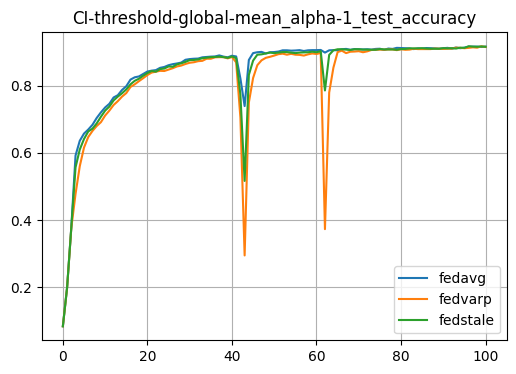

,algorithm,availability,alpha,participation,max_test_accuracy,test_accuracy,test_loss,train_accuracy,train_loss,seed,lr,event,n_clients
1,fedavg,CI-threshold-median,-1,known,93.173528,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7
11,fedvarp,CI-threshold-median,-1,known,91.766542,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7
21,fedstale,CI-threshold-median,-1,known,92.704535,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7


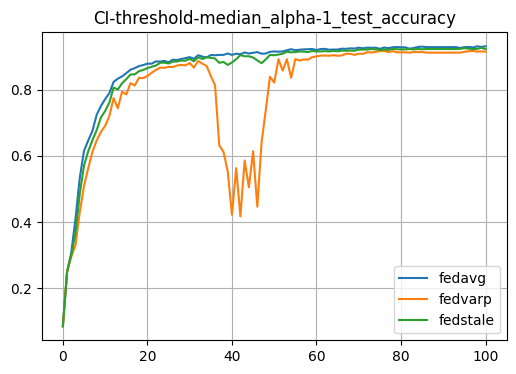

,algorithm,availability,alpha,participation,max_test_accuracy,test_accuracy,test_loss,train_accuracy,train_loss,seed,lr,event,n_clients
2,fedavg,CI-threshold-penalized-local-mean,-1,known,92.027098,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7
12,fedvarp,CI-threshold-penalized-local-mean,-1,known,91.766542,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7
22,fedstale,CI-threshold-penalized-local-mean,-1,known,91.870767,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7


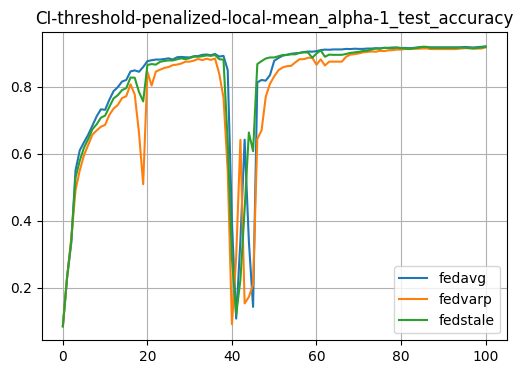

,algorithm,availability,alpha,participation,max_test_accuracy,test_accuracy,test_loss,train_accuracy,train_loss,seed,lr,event,n_clients
3,fedavg,carbon-budget,-1,known,92.443979,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7
13,fedvarp,carbon-budget,-1,known,92.027098,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7
23,fedstale,carbon-budget,-1,known,92.131317,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7


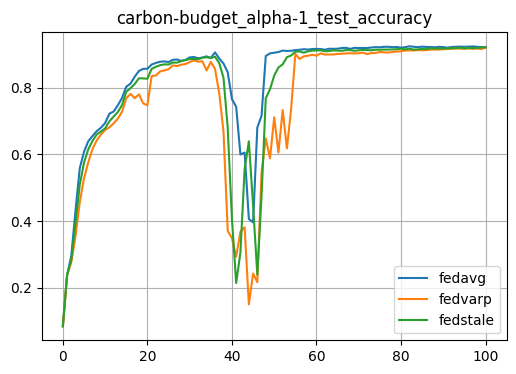

,algorithm,availability,alpha,participation,max_test_accuracy,test_accuracy,test_loss,train_accuracy,train_loss,seed,lr,event,n_clients
4,fedavg,carbon-budget-fine-tuning,-1,known,90.828556,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7
14,fedvarp,carbon-budget-fine-tuning,-1,known,91.193330,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7
24,fedstale,carbon-budget-fine-tuning,-1,known,91.141218,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7


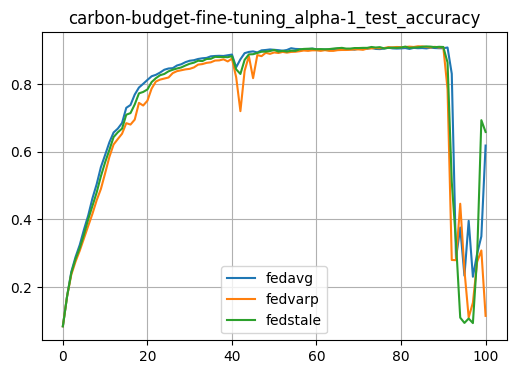

,algorithm,availability,alpha,participation,max_test_accuracy,test_accuracy,test_loss,train_accuracy,train_loss,seed,lr,event,n_clients
5,fedavg,random_for_CI-threshold-global-mean,-1,known,91.453880,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7
15,fedvarp,random_for_CI-threshold-global-mean,-1,known,91.401774,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7
25,fedstale,random_for_CI-threshold-global-mean,-1,known,91.453880,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7


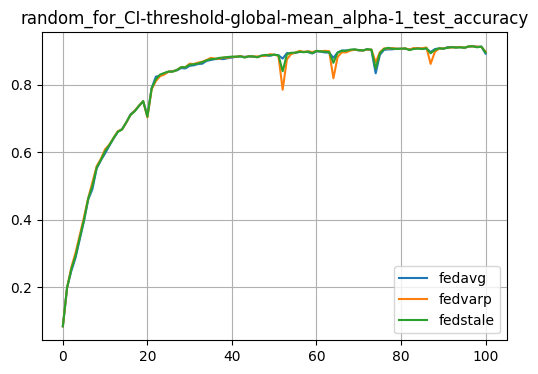

,algorithm,availability,alpha,participation,max_test_accuracy,test_accuracy,test_loss,train_accuracy,train_loss,seed,lr,event,n_clients
6,fedavg,random_for_CI-threshold-penalized-local-mean,-1,known,93.069309,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7
16,fedvarp,random_for_CI-threshold-penalized-local-mean,-1,known,93.121415,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7
26,fedstale,random_for_CI-threshold-penalized-local-mean,-1,known,93.069309,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7


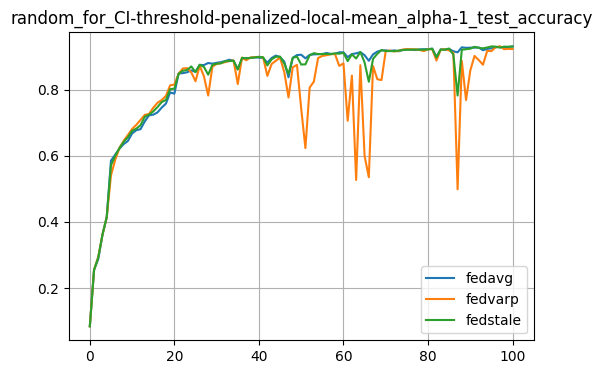

,algorithm,availability,alpha,participation,max_test_accuracy,test_accuracy,test_loss,train_accuracy,train_loss,seed,lr,event,n_clients
7,fedavg,random_for_CI-threshold-median,-1,known,93.121415,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7
17,fedvarp,random_for_CI-threshold-median,-1,known,93.277746,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7
27,fedstale,random_for_CI-threshold-median,-1,known,93.225640,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7


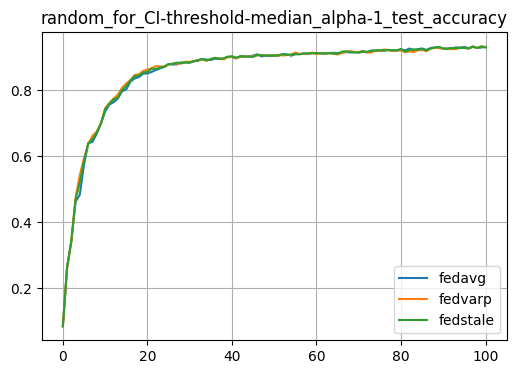

,algorithm,availability,alpha,participation,max_test_accuracy,test_accuracy,test_loss,train_accuracy,train_loss,seed,lr,event,n_clients
8,fedavg,random_for_carbon-budget,-1,known,93.069309,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7
18,fedvarp,random_for_carbon-budget,-1,known,93.277746,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7
28,fedstale,random_for_carbon-budget,-1,known,93.225640,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7


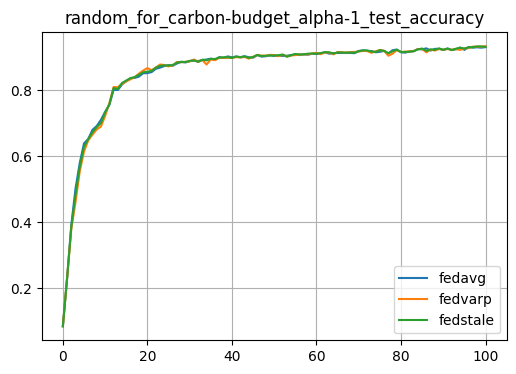

,algorithm,availability,alpha,participation,max_test_accuracy,test_accuracy,test_loss,train_accuracy,train_loss,seed,lr,event,n_clients
9,fedavg,random_for_carbon-budget-fine-tuning,-1,known,93.277746,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7
19,fedvarp,random_for_carbon-budget-fine-tuning,-1,known,93.225640,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7
29,fedstale,random_for_carbon-budget-fine-tuning,-1,known,93.225640,Test/Metric,Test/Loss,Train/Metric,Train/Loss,12,5e-3,global,7


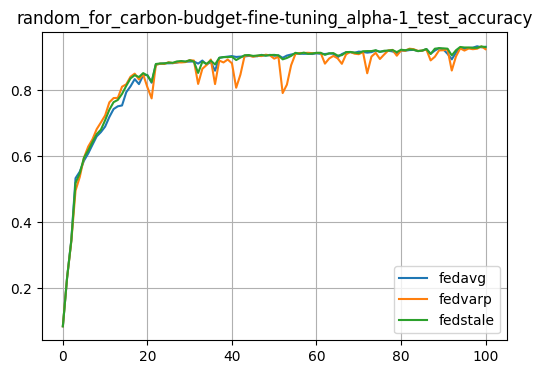

In [109]:
import matplotlib.pyplot as plt

def plot_algorithms_comparison(config, res, metric):

    
    xvalues = [i for i in range(int(config.n_rounds)+1)]

    for lr in config.lr_list:
        
        for event in config.events:
            for seed in config.seeds:
                for a in config.alphas:
                    for n_c in config.n_clients_list:
                        # for av in config.availabilities:
                        for part in config.participations:
                                    
                            for av in config.availabilities:

                                res_tmp = res[(res.lr == lr) & (res.availability == av) & (res.event == event) &
                                            (res.seed == seed) & (res.alpha == a) & (res.n_clients == n_c) &
                                            (res.participation == part)]
                                
                                display(res_tmp) # this is what we are going to compare
                                
                                fig = plt.figure(figsize=(6, 4))
                                
                                
                                for algo in config.algorithms:
                                    
                                    res_plot = res_tmp[res_tmp.algorithm == algo]
                                    event_dir = config.get_event_dir(algo, lr, seed, 
                                                                    event, a, n_c, av, 
                                                                    config.n_rounds, part)  
                                    # display(res_plot)
                                    # print('xxx')
                                    tag = res_plot[metric].values[0]
                                    _, test_accuracy_values = parse_tf_events_file(event_dir, tag=tag)
                                    # print(av)
                                    # yvalues = res_plot[(res_plot.availability == av)][metric]
                                    # print(res_plot[(res_plot.availability == av)][metric])
                                    plt.plot(xvalues, test_accuracy_values, label= algo)
                                    title = ('_').join([av, 'alpha'+a, metric])
                                    plt.title(title)
                                plt.legend()
                                plt.grid()
                                plt.savefig('figures/accross_algorithms/'+title+'.png', bbox_inches='tight')
                                plt.show()
    
plot_algorithms_comparison(config, results_df, "test_accuracy")

In [ ]:
# fig = plt.figure(figsize=(8, 4))

# for country_idx, country in enumerate(countries):

#     df_country = _dfs[country]
#     df_to_plot = df_country[df_country['datetime'].between(start_date,end_date)]

#     # plot:
#     plt.plot(df_to_plot['datetime'].values, df_to_plot['CI_direct'].values, label=country, color = list_colors[country_idx])

#     # plot legend, axis, etc.:
#     # ax.set_xlim([df_to_plot['datetime'].values[0], df_to_plot['datetime'].values[-1]])
#     plt.title('Carbon Intensity time evolution')
#     plt.legend()
#     # ax.xaxis.set_major_formatter(mdates.DateFormatter("%d"))
#     # ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
#     _ = plt.xticks(rotation=90)  
#     plt.grid()
#     plt.xticks(rotation=45, ha='right')  # rotate x-axis labels to diagonal
#     plt.ylabel('CI (gCO2eq/kWh)')
# plt.savefig(os.path.join('figures/raw_CI_data.png'), bbox_inches='tight')

## Appendix

In [ ]:

# from tensorflow.python.summary.summary_iterator import summary_iterator

# for summary in summary_iterator("./logs/mnist_CI_based_availability/clients_7/local_mean/fedavg/known_participation_probs/alpha_0.1/lr_5e-3/seed_12/rounds_100"):
#     print(summary)

folder = './logs/mnist_CI_based_availability/clients_7/local_mean/fedavg/known_participation_probs/alpha_0.1/lr_5e-3/seed_12/rounds_100/train/global/events.out.tfevents.1717493789.C11-8C4G9B45HOX.12548.7'
# folder = './logs'

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
event_acc = EventAccumulator(folder)
event_acc.Reload()
# Show all tags in the log file
print(event_acc.Tags())

# w_times, step_nums, vals = zip(*event_acc.Scalars('Train/Loss'))

# print(*event_acc.Scalars('Train/Loss'))


event_acc.Scalars('Train/Loss')

In [2]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def parse_tf_events_file(events_path, tag, time_horizon=None):
    # extract the list of steps (FL rounds) and the list or corresponding values
    ea = EventAccumulator(events_path).Reload()
    tag_values, steps = [], []
    for event in ea.Scalars(tag):
        if time_horizon is None or event.step <= time_horizon:
            tag_values.append(event.value)
            steps.append(event.step)
    return steps, tag_values


class ExperimentConfig:
    def __init__(self, base_path, experiment, seeds, algorithms, events, heterogeneities, b_values, lr_dict
                 ):
        self.base_path = base_path
        self.experiment = experiment
        self.seeds = seeds
        self.algorithms = algorithms
        self.events = events
        self.heterogeneities = heterogeneities
        self.b_values = b_values
        self.lr_dict = lr_dict

    def get_event_dir(self, p, h, algorithm, lr, b, seed, event):
        path = f"{self.base_path}/{self.experiment}/p_{p}/h_{h}"
        path += f"/{algorithm}/b_{b}" if algorithm == "mixture" else f"/{algorithm}"
        path += f"/lr_{lr}/seed_{seed}/train/{event}"
        return path

parse_tf_events_file(folder, 'Train/Loss')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100],
 [2.3053338527679443,
  2.260401725769043,
  2.2076103687286377,
  2.0828468799591064,
  1.8212461471557617,
  1.6342271566390991,
  1.4341044425964355,
  1.2726633548736572,
  1.1403427124023438,
  1.178110957145691,
  0.8990321159362793,
  0.8210407495498657,
  0.7579436898231506,
  0.7097863554954529,
  0.6728664040565491,
  0.6978819370269775,
  0.6431033611297607,
  0.6291451454162598,
  0.7222